In [17]:
import urllib2

import gensim
import nltk
import numpy as np
import pandas as pd

from keras import models, layers, optimizers, backend
from seaborn import plt

%matplotlib inline
from IPython.core.pylabtools import figsize

In [2]:
# http://www.clickhole.com/blogpost/time-i-spent-commercial-whaling-ship-totally-chang-768
moby_url = "http://www.gutenberg.org/files/2701/2701.txt"
moby_txt = urllib2.urlopen(moby_url).read()

In [58]:
class BytePairEncoder(object):
    
    def __init__(
            self,
            max_vocab_size=None, vocab_size_heuristic_cutoff=4,
            freq_transform=lambda x: np.maximum(x, 0),
            normalizer=lambda s: s, tokenizer=nltk.tokenize.casual_tokenize,
            word_boundaries=False, start_char="^", end_char="`", word_sep=" "):
        self._max_vocab_size = max_vocab_size
        self._vocab_size_heuristic_cutoff = vocab_size_heuristic_cutoff
        self._freq_transform = freq_transform
        self._raw_normalizer = normalizer
        self._tokenizer = tokenizer
        self._word_boundaries = word_boundaries
        self._start_char = start_char
        self._end_char = end_char
        self._word_sep = word_sep
        self._word_freqs = {}
        self._pairs_to_words = {}
        self._pairs_to_freqs = {}
        self._code_children = {}
        self._char_encoder = {}
        self._word_reprs = {}
        self._next_code = 0
        self._decoder = {}
        self._encoder = {}
        self._unk = None
        self._word_start = None
        self._word_end = None
        self._largest_width = 0
    
    def _normalizer(self, s):
        if self._word_boundaries:
            return self._raw_normalizer(
                s).replace(self._start_char, "").replace(self._end_char, "")
        else:
            return self._raw_normalizer(s)
        
    def _infer_max_vocab_size(self, raw_freqs):
        self._max_vocab_size = (raw_freqs > self._vocab_size_heuristic_cutoff).sum()
    
    def _base_word_repr(self, w):
        wrepr = [self._char_encoder[char] for char in w]
        if self._word_boundaries:
            return [self._word_start] + wrepr + [self._word_end]
        else:
            return wrepr

    def _compile_dictionary(self, x):
        x = self._normalizer(x)
        raw_freqs = pd.Series(self._tokenizer(x)).value_counts()
        if self._max_vocab_size is None:
            self._infer_max_vocab_size(raw_freqs)
        self._word_freqs = dict(self._freq_transform(raw_freqs))
        self._code_children = dict(enumerate(set(x)))
        max_char_key = max(self._code_children.keys())
        if self._word_boundaries:
            self._word_start, self._word_end, self._next_code = np.arange(1, 4) + max_char_key
            self._code_children[self._word_start] = self._start_char
            self._code_children[self._word_end] = self._end_char
        else:
            self._next_code = max_char_key + 1
        self._char_encoder = dict((v, k) for k, v in self._code_children.items())
        self._word_reprs = dict([
            (word, self._base_word_repr(word))
            for word in self._word_freqs])

    def _iterpairs(self, wrepr):
        return (p for p in zip(wrepr[:-1], wrepr[1:]) if len(p) == 2)
    
    def _index_pair_in_word(self, pair, word, freq=None):
        if freq is None:
            freq = self._word_freqs[word]
        if pair not in self._pairs_to_words:
            self._pairs_to_words[pair] = set()
        self._pairs_to_words[pair].add(word)
        if pair not in self._pairs_to_freqs:
            self._pairs_to_freqs[pair] = 0
        self._pairs_to_freqs[pair] += freq

    def _index_codepairs(self):
        self._pairs_to_words = {}
        self._pairs_to_freqs = {}
        for word, freq in self._word_freqs.iteritems():
            wrepr = self._word_reprs[word]
            for pair in self._iterpairs(wrepr):
                self._index_pair_in_word(pair, word, freq)

    def _top_pair(self):
        return max(
            self._pairs_to_freqs.iterkeys(),
            key=lambda k: self._pairs_to_freqs[k])

    def _expand_vocab(self):
        top = self._top_pair()
        code = self._next_code
        self._next_code += 1
        del self._pairs_to_freqs[top]
        self._code_children[code] = top
        for word in self._pairs_to_words[top]:
            self._merge_in_word(word, top, code)

    def _finalize_vocab(self):
        for code in np.arange(self._max_vocab_size):
            children = self._code_children[code]
            if isinstance(children, str):
                self._decoder[code] = children
            else:
                decoding = ""
                for child in children:
                    if isinstance(child, str):
                        decoding += child
                    else:
                        decoding += self._decoder[child]
                self._decoder[code] = decoding
        self._encoder = dict((v, k) for k, v in self._decoder.iteritems())
        self._unk = self._max_vocab_size + 1
        self._decoder[self._unk] = ":UNK:"
        self._largest_width = max(len(w) for w in self._encoder)

    def _build_vocab(self):
        while self._next_code <= self._max_vocab_size:
            self._expand_vocab()
        self._finalize_vocab()
    
    def _deindex_pair_in_word(self, pair, word):
        freq = self._word_freqs[word]
        self._pairs_to_words[pair].discard(word)
        self._pairs_to_freqs[pair] -= freq
    
    def _merge_in_word(self, word, old_pair, new_code):
        wrepr = self._word_reprs[word]
        pairs_before = set(self._iterpairs(wrepr))
        new_wrepr = []
        left = wrepr[0]
        for right in wrepr[1:]:
            if (left, right) == old_pair:
                new_wrepr.append(new_code)
                left = new_code
            else:
                if left != new_code:
                    new_wrepr.append(left)
                left = right
        if left != new_code:
            new_wrepr.append(right)
        self._word_reprs[word] = new_wrepr
        pairs_after = set(self._iterpairs(new_wrepr))
        for novel_pair in pairs_after - pairs_before:
            self._index_pair_in_word(novel_pair, word)
        for extinct_pair in pairs_before - pairs_after - set([old_pair]):
            self._deindex_pair_in_word(extinct_pair, word)

    def _encoding_step(self, tok):
        steps = min(self._largest_width, len(tok))
        for width in steps - np.arange(steps):
            chunk = tok[:width]
            code = self._encoder.get(chunk)
            if code is not None:
                return code, width
        return self._unk, 1
    
    def _encode_token(self, tok):
        encoded = []
        i = 0
        while i < len(tok):
            code, width = self._encoding_step(tok[i:])
            encoded.append(code)
            i += width
        return encoded
    
    def _token_with_start_and_end(self, tok):
        return "{s}{t}{e}".format(
            s=self._start_char, t=tok, e=self._end_char)
    
    def fit(self, x):
        self._compile_dictionary(x)
        self._index_codepairs()
        self._build_vocab()
        return self

    def encode(self, x):
        if self._word_boundaries:
            encoded_tokens = [
                self._encode_token(self._token_with_start_and_end(tok))
                for tok in self._tokenizer(self._normalizer(x))]
            return np.concatenate(encoded_tokens)
        else:
            return self._encode_token(x)
    
    def decode(
            self, x, as_list=False,
            segment_boundaries=False, word_boundaries=False, whitespace=True):
        decoded = [self._decoder[code] for code in x]
        if as_list:
            return decoded
        else:
            join_char = "•" * segment_boundaries
            s = join_char.join(self._decoder[code] for code in x)
            if whitespace:
                s = s.replace(
                    self._end_char + join_char + self._start_char,
                    self._end_char + self._word_sep + self._start_char)
            if not word_boundaries:
                s = s.replace(self._start_char, "").replace(self._end_char, "")
            return s
    
    def segment(self, x):
        return self.decode(
            self.encode(x),
            segment_boundaries=True, word_boundaries=True)
    
    def transform(self, x):
        return np.array([self.encode(sent) for sent in x])
    
    def inverse_transform(self, x, as_list=False):
        return np.array([self.decode(sent, as_list=as_list) for sent in x])

In [59]:
bpe = BytePairEncoder().fit(moby_txt)
lbpe = BytePairEncoder(freq_transform=lambda freq: np.log(freq) + 1).fit(moby_txt)
ubpe = BytePairEncoder(freq_transform=lambda freq: np.minimum(freq, 1)).fit(moby_txt)

In [72]:
print bpe.segment("Good heavens, whatever can have come over you on this morning?").replace("• •", " ")

Good heavens•, whatever can have come over you on this morning•?


In [73]:
print lbpe.segment("Good heavens, whatever can have come over you on this morning?").replace("• •", " ")

Good heaven•s•, what•ever can have come over you on this morning•?


In [74]:
print ubpe.segment("Good heavens, whatever can have come over you on this morning?").replace("• •", " ")

Good heaven•s•, what•ever can hav•e come over you on this morn•ing•?


In [65]:
fs = pd.Series(bpe._word_freqs)
freqs = pd.DataFrame({"word": fs.index, "freq": fs})
freqs.sort_values("freq", ascending=False, inplace=True)
freqs.reset_index(drop=True, inplace=True)
freqs["bpe"] = freqs.word.map(bpe.segment)
freqs["lbpe"] = freqs.word.map(lbpe.segment)
freqs["ubpe"] = freqs.word.map(ubpe.segment)
freqs["n_bpe"] = freqs.word.map(bpe.encode).map(len)
freqs["n_lbpe"] = freqs.word.map(lbpe.encode).map(len)
freqs["n_ubpe"] = freqs.word.map(ubpe.encode).map(len)

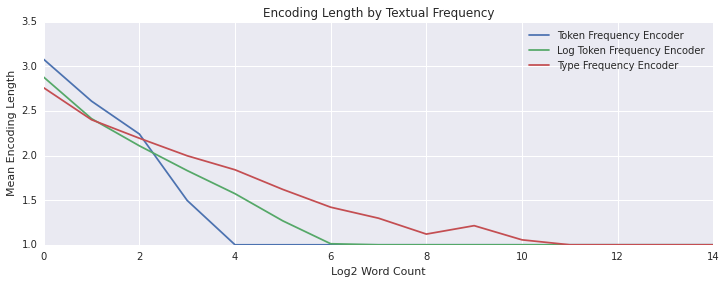

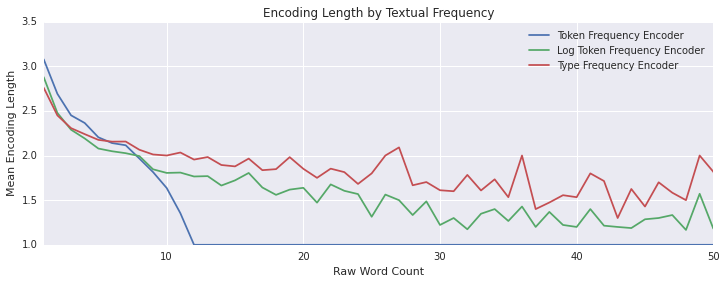

In [66]:
figsize(12, 4)
to_plot = freqs.groupby(np.log2(freqs.freq).astype(int)).mean()[["n_bpe", "n_lbpe", "n_ubpe"]]
to_plot.columns = ["Token Frequency Encoder", "Log Token Frequency Encoder", "Type Frequency Encoder"]
to_plot.plot()
plt.xlabel("Log2 Word Count")
plt.ylabel("Mean Encoding Length")
plt.title("Encoding Length by Textual Frequency")
plt.show()

to_plot = freqs.groupby(freqs.freq).mean()[["n_bpe", "n_lbpe", "n_ubpe"]]
to_plot.columns = ["Token Frequency Encoder", "Log Token Frequency Encoder", "Type Frequency Encoder"]
to_plot.plot()
plt.xlabel("Raw Word Count")
plt.ylabel("Mean Encoding Length")
plt.title("Encoding Length by Textual Frequency")
plt.xlim(1, 50)
plt.show()

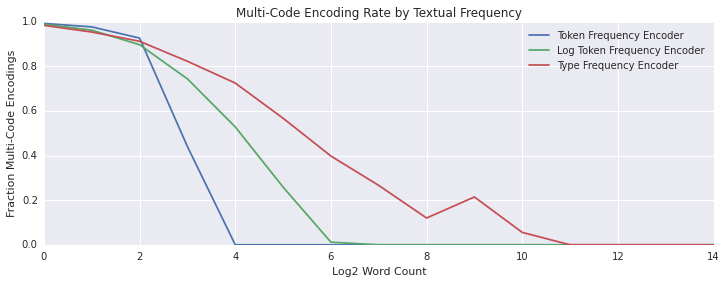

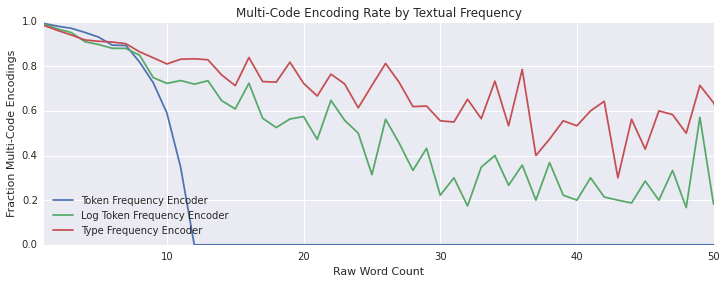

In [67]:
to_plot = freqs.groupby(np.log2(freqs.freq).astype(int)).agg(lambda x: np.mean(x > 1))[["n_bpe", "n_lbpe", "n_ubpe"]]
to_plot.columns = ["Token Frequency Encoder", "Log Token Frequency Encoder", "Type Frequency Encoder"]
to_plot.plot()
plt.xlabel("Log2 Word Count")
plt.ylabel("Fraction Multi-Code Encodings")
plt.title("Multi-Code Encoding Rate by Textual Frequency")
plt.show()

to_plot = freqs.groupby(freqs.freq).agg(lambda x: np.mean(x > 1))[["n_bpe", "n_lbpe", "n_ubpe"]]
to_plot.columns = ["Token Frequency Encoder", "Log Token Frequency Encoder", "Type Frequency Encoder"]
to_plot.plot()
plt.xlabel("Raw Word Count")
plt.ylabel("Fraction Multi-Code Encodings")
plt.title("Multi-Code Encoding Rate by Textual Frequency")
plt.xlim(1, 50)
plt.show()

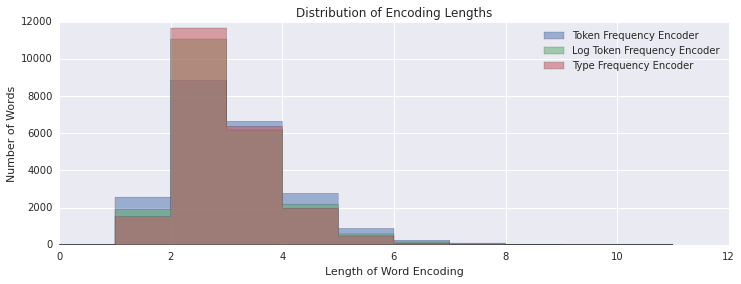

In [68]:
plt.hist(freqs.n_bpe, histtype="stepfilled", bins=np.arange(12), alpha=0.5, label="Token Frequency Encoder")
plt.hist(freqs.n_lbpe, histtype="stepfilled", bins=np.arange(12), alpha=0.5, label="Log Token Frequency Encoder")
plt.hist(freqs.n_ubpe, histtype="stepfilled", bins=np.arange(12), alpha=0.5, label="Type Frequency Encoder")
plt.ylabel("Number of Words")
plt.xlabel("Length of Word Encoding")
plt.title("Distribution of Encoding Lengths")
plt.legend()
plt.show()

In [77]:
for s in moby_txt.split(".")[4000:4010]:
    print lbpe.segment(s.replace("\r\n", " ")).replace("• •", " ").strip().strip("•").strip() + ".\n"

In the dist•ance•, a great white mass la•z•ily rose•, and ris•ing high•er and high•er•, and dis•ent•angl•ing itself from the az•ure•, at last gleam•ed before our pro•w like a snow•-•sli•de•, new sli•d from the hill•s.

Th•us gli•ste•ning for a moment•, as slow•ly it sub•sided•, and san•k.

The•n once more ar•ose•, and sil•ently gleam•ed.

It seemed not a whale•; and yet is this Moby Dick•? thought Daggoo.

A•gain the phant•om went down•, but on re-•appear•ing once more•, with a st•ile•tt•o•-like cry that start•led every man from his nod•, the negro ye•ll•ed out•--•"•There•! there again•! there she bre•aches•! right ahead•! The White Whale•, the White Whale•!•"  •Up•on this•, the seamen rushed to the yard-•arms•, as in sw•arm•ing-•time the be•es rush to the bo•ug•h•s.

Bar•e-•headed in the sult•ry sun•, Ahab stood on the bows•pri•t•, and with one hand pu•shed far be•hind in read•iness to wa•ve his orders to the helm•sm•an•, cast his eager gl•ance in the direct•ion indic•ated aloft by th

In [70]:
ubpe.encode("silently")

[1074, 460]

In [76]:
freqs[freqs.word.map(lambda w: 460 in ubpe.encode(w))]

,freq,word,bpe,lbpe,ubpe,n_bpe,n_lbpe,n_ubpe
1457,15,frequently,frequently,frequ•ently,frequ•ently,1,2,2
1491,14,silently,silently,sil•ently,sil•ently,1,2,2
2256,9,apparently,apparent•ly,appar•ently,appar•ently,2,2,2
2434,9,violently,violent•ly,viol•ently,viol•ently,2,2,2
2827,7,diligently,dil•ig•ently,dilig•ently,dil•ig•ently,3,2,3
3475,6,Presently,P•res•ently,Pres•ently,Pres•ently,3,2,2
4914,4,subsequently,subsequent•ly,subsequ•ently,subs•equ•ently,2,2,3
5600,3,consequently,consequ•ently,consequ•ently,consequ•ently,2,2,2
5626,3,unfrequently,un•frequently,unf•requ•ently,unf•requ•ently,2,3,3
6202,3,impatiently,impat•iently,impat•iently,imp•ati•ently,2,2,3
